<h1> Exercises 1: Basic Radar Processing </h1>
In this notebook we have a few exercises and examples of code such that you can run it, play around with it to better understand how radar signal processing is performed in Python. 

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io as sio
import processing.save_adc_data as sd
import processing._process_data as pd

<h5> 1. Setting up Paths and Loading Data: </h5>
To load your data, please make sure the file paths are all correct. The variables/functions are setup expecting a specific way of your project directory organization, however it is up to you how you want to organize it. Step through these variables to make sure you are loading what is expected. 

In the end, it is up to you how you want to link the paths. We've set it up in a way that should work if you follow the path conventions however you are welcome to look through all the functions called in order to determine how you want to input path names. Since the size of the data depends on your specific chirp paramters (such as number of frames, number of transmitters used, number of receivers used, number of chirp loops used, number of ADC samples used), we will leave this code for you understand whether you need to make changes for your future project.

In [3]:
# TODO: Put the *name* of your .bin file here (excluding the .bin)
filename = r"1"
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"
# TODO: Put the path (relative to home_dir) of the captured data folder
capture_data_dir = r"data"
# TODO: Put the path (relative to home_dir) and name of the JSON files (exlude the .setup.json and .mmwave.json)
json_filename = r"scripts/chirp1"
path_to_rawdata = os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat')
bin_data = sio.loadmat(os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat'))
config_lua_script = r'scripts/1843_config.lua' 

# this function reads the parameters from your lua config file (look at this function to see how it expects your config file to be formatted)
num_tx, num_rx, adc_samples, chirp_loops = sd.read_lua(os.path.join(home_dir,config_lua_script))

######### only edit here if you want to change the chirp paramters!!!! #############
tx_en = '0x7' # HEX enable (1 for on, 0 for off)
rx_en = '0xF' # HEX enable (1 for on, 0 for off)

args = [num_tx, num_rx, adc_samples, chirp_loops, tx_en, rx_en]

Loading the data requires loading the *.bin file you measured and converting it to a *.mat file. You only have to do this conversion once if the data has not changed in that file. Then we load the *.mat file and extract the raw data.

In [4]:
############################# Reformat the Data #############################
if not os.path.exists(os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat')):
    sd.save_adc_data(filename, home_dir, capture_data_dir, json_filename)

################################# load data #################################
bin_data = sio.loadmat(os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat'))
raw_data = np.array(bin_data['data_raw'])

print("You captured %d frames, for %d TX, %d Rx, and %d adc samples" % raw_data.shape)

You captured 20 frames, for 3 TX, 4 Rx, and 512 adc samples


<h5> 2. Range FFT: </h5> 

There is some simple signal processing we can do to have a coarse understanding of what we've received. Below, is code for processing and plotting the range FFT as you have seen in the lectures, AKA we take the FFT of the raw signal (along the dimension of the ADC samples). Based on this you should also be able to locate the strongest reflector and recover the distance of that reflector. 

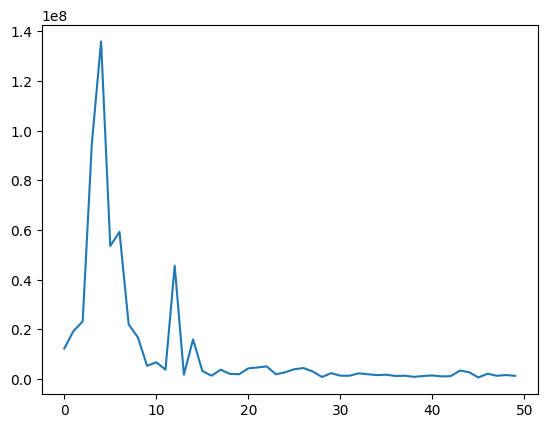

In [5]:
############################### process data! ################################
# Range FFT
rfft = scipy.fft.fft(raw_data, axis=3)
plt.plot(abs(np.squeeze(np.sum(rfft[:,:,:,0:50],axis=(0,2,1)))))

Now find the distance of the maximum reflector that is seen in front of the radar.

In [6]:
######## Find the distance of the maximum reflector in front of the radar. #############
# TODO: add your code here
def max_reflector(rfft):
    # put your implementation here
    return

In [7]:
max_reflector(rfft)

<h5> 3. Beamforming </h5>

To help understand some of the ways to visualize radar data better, we have provided some processed data and some examples of Python plotting code to play around with. First we will go through the process of beamforming and show the bird eye view (BEV) heatmaps we can recover from this.
For beamforming, it requires knowing a few details about the antenna array that captured the data. We will describe it in more detail below.
For the rest of this section, the horizontal dimension will be defined as *x*, vertical as *z*, and depth will be defined by *y*. 

First, we load the data provided.


In [56]:
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"

# loading data that is given
filename = r"data_001"
data_dir = r"given_data"
mat_data = sio.loadmat(os.path.join(home_dir,data_dir,filename + '.mat'))
raw_data = mat_data['adcData']
num_x_stp, num_z_stp, num_tx, num_rx, adc_samples = raw_data.shape
X = raw_data[num_x_stp//2,num_z_stp//2,:,:,:]

In this exercise, we are only using 4 receivers and the first transmitter. In this case, you can look up the antenna pattern on the documentation for the AWR1843 radar. You will see a much larger array in the next exercise. 

In [168]:
# define the antenna spacing
lm = 3e8/77e9 # define lambda for the antenna spacing
rx_pos = np.reshape(np.arange(1,5,dtype=float),(-1,1)) * -lm / 2
rx_pos = rx_pos - rx_pos[0]
ant_pos = rx_pos
print(ant_pos)

[[ 0.        ]
 [-0.00194805]
 [-0.0038961 ]
 [-0.00584416]]


In some cases, there is a lot of self-interference between the antennas when we scan, and it appears as a very very strong signal very close to the radar. Thus, we sometimes will pass the raw signal through a highpass filter to get rid of the strong signals at the lower frequencies. You can try with and without this highpass filter and see how it affects the images. 

In [169]:
# just look at one vertical dimension since we are not using elevation
beat_freq = scipy.fft.fft(X, axis=-1)
beat_freq = np.reshape(beat_freq,(-1,adc_samples))


In [184]:
################# Change the values based on how much of the azimuth angles you want to see and the resolution ##################
# Define field of view in degrees that you want to process in theta 
def beamform_1d(beat_freq_data, theta_s, theta_e, theta_res, locs):

    # Convert everything to Radians 
    theta_s_r = theta_s * (np.pi/180)
    theta_e_r = theta_e * (np.pi/180)
    theta_res*= (np.pi/180)
    theta_rad_lim = [theta_s_r,theta_e_r]

    # Generate arrays for theta 
    theta = np.arange(theta_rad_lim[0], theta_rad_lim[1], theta_res)
    N_theta = len(theta)

    # Initialize arrays for spherical power
    sph_pwr = np.zeros((N_theta, adc_samples), dtype=complex)

    print("Running this many iterations: %d " % (N_theta))

    ######################## BF Calculations ###########################3
    for kt in range(N_theta):
        cos_theta = np.cos(theta[kt]) # angle that the signal is coming from 
        Vec = np.exp(1j*(2*np.pi*(locs*cos_theta)/lm))
        VecRFI = np.squeeze(np.repeat(Vec[:, np.newaxis], adc_samples, axis=1))
        sph_pwr[kt, :] = np.squeeze(np.sum(np.multiply(np.squeeze(beat_freq_data),VecRFI), axis=(0)))        
        print("Processed angle (%.2f)" % (theta[kt]*180/np.pi), end='\r')
    return sph_pwr, theta

Once we've performed beamforming on this 1D array, we can plot the corresponding images. In this example below, we have plotted the birds eye view for you. You can play around with the normalization to see how different thresholds impact the final image and what reflectors you can see. 

In [185]:
# define the azimuth angles (horizontal FOV) that we want to look at 
theta_s, theta_e = 0, 180
theta_res = 1
print(beat_freq.shape)
bf_output, theta = beamform_1d(beat_freq, theta_s,theta_e,theta_res, ant_pos)

(4, 512)
Running this many iterations: 180 


(180, 512)


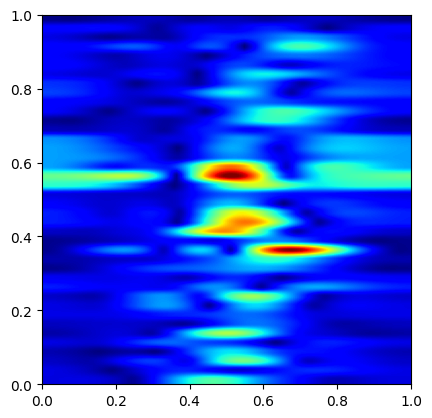

In [186]:
print(bf_output.shape)
to_plot = bf_output[:,:]
to_plot = to_plot[:,100:140]
to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1)))
plt.imshow(abs((to_plot).T), extent=[0,1,0,1],cmap = 'jet',  vmin=0, vmax=1) # this is giving the y axis in meters, and x axis in angles 

<h5> 4. Matched Filter:</h5> 
Here we will compute the matched filter output for the captured data. We calculate the round trip distance of each point in x,y,z, and correlate it with the raw data. 


In [176]:
######## 1D Imaging in Cartesian #############
def matched_filter_1d(raw_data_1d, num_x_cells, num_y_cells, ant_pos):
    c = 2.9979
    fc_start =  773.704
    chirpSlope = 70.295e12
    adcSampleRate = 10e6
    As_sci = (chirpSlope/1e8)


    MF_output = np.zeros((len(num_x_cells),len(num_y_cells)),dtype=complex)

    for i,cell_x in enumerate(num_x_cells):
        for j,cell_y in enumerate(num_y_cells):
                x_radar_tx = ant_pos - 0.005 - 3 * lm / 2
                x_radar_rx = ant_pos
                
                cell_dist = np.sqrt((x_radar_tx - cell_x)**2 + (cell_y)**2) + np.sqrt((cell_x - x_radar_rx)**2 + (cell_y)**2)
                cell_dist = cell_dist + 0.15 # account for range bias
                temp_tau = (cell_dist)/c
                
                temp_sig_phase = 2.0*np.pi*fc_start*temp_tau
                total_phase = np.repeat(temp_sig_phase,adc_samples,axis=1) + 2.0 * np.pi * As_sci * (np.arange(0,adc_samples).T / adcSampleRate) * temp_tau
                temp_real = np.cos(total_phase)
                temp_imag = -np.sin(total_phase)
                MF_output[i,j] = MF_output[i,j] + np.sum((raw_data_1d *  (temp_real + temp_imag*1j)),axis=(0,1))
                            
                print("Processed cell (%.2f,%.2f)" % (cell_x,cell_y), end='\r')
    return MF_output 

In [177]:
X = np.squeeze(raw_data[num_x_stp//2,num_z_stp//2,:,:,:]) # for matched filter we use the raw data directly!
X = np.reshape(X,(-1,adc_samples))
num_x_cells = np.arange(-1,1,0.02)
num_y_cells = np.arange(4,6,0.2)
print(X.shape)

MF_output = matched_filter_1d(X, num_x_cells, num_y_cells, ant_pos)

(4, 512)


Now we will plot the heatmap computed below.

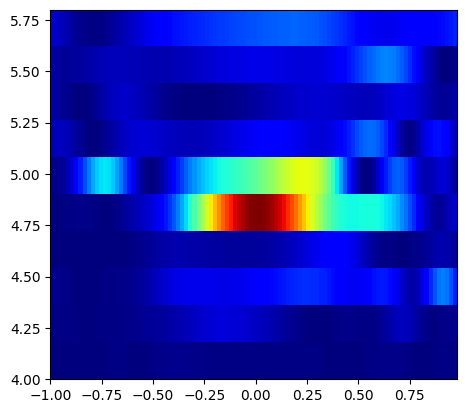

In [178]:
to_plot = (MF_output[::-1,::-1])**2
plt.imshow(abs(to_plot.T), extent=[num_x_cells[0], num_x_cells[-1], num_y_cells[0], num_y_cells[-1]],cmap = 'jet') # this is giving the y axis in meters, and x axis in angles 